In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ipdb
from scipy.special import expit

In [2]:
class Layer:

    #Activation Functions
    def tanh(self, x):
        return np.tanh(x)
    def d_tanh(self, x):
        return 1 - np.square(np.tanh(x))
    def sigmoid(self, x):
#         return 1/(1+ np.exp(-x))
        return expit(x)
    def d_sigmoid(self, x):
        return (1 - self.sigmoid(x)) * self.sigmoid(x)
    def ReLu(self, z):
        return np.maximum(0, z)
    def d_ReLu(self, Z):
        return Z > 0
    
    #For output layer, useful for multiclass classification
    def softmax(self, Z):
#         expZ = np.exp(Z - np.max(Z))
#         return expZ / expZ.sum(axis=0, keepdims=True)
         return np.exp(Z) / sum(np.exp(Z))
    def d_softmax(self, Z):
        pass
    
    activationFunctions = {
        'tanh': (tanh, d_tanh),
        'sigmoid': (sigmoid, d_sigmoid),
        'reLu': (ReLu, d_ReLu),
        'softmax': (softmax, d_softmax)
    }
    
    #Input -> num of neurons in prev layer, Neurons --> num neurons in cur layer, Activation -> activation fxn to use
    def __init__(self, inputs, neurons, activation):
        self.neurons = neurons
        self.W = np.random.rand(neurons, inputs) - 0.5
        self.b = np.random.rand(neurons, 1) - 0.5
        self.Z = None
        self.A_prev = None
        self.act, self.d_act = self.activationFunctions.get(activation)
        
    def initializeWeights(self, inputs, neurons):
        self.W = np.random.rand(neurons, inputs) - 0.5
        
    def getNeuronCount(self):
        return self.neurons
    
    def getWeights(self):
        return self.W;
    
    def feedForward(self, A_prev):
        #ipdb.set_trace()
        self.A_prev = A_prev
        self.Z = self.W.dot(self.A_prev) + self.b
        self.A = self.act(self, self.Z)
        return self.A
    
    #All derivatives are wrt to cost
    #Expects dA of cur layer
    #Special case where doing multi class classification with mutli class logloss, you can get the dZ wrt dC directly without having to first get dA
    def backprop(self, dA, learning_rate, dZ_Special):
        
        #ipdb.set_trace()
        
        #elementt by element matrix multip, not a normal dot prod since both matrices have same shape (essentialyl scalar)
        dZ = np.multiply(self.d_act(self, self.Z), dA) if dZ_Special.any() == None else dZ_Special
        
         # need to normalize weights and divide by number of samples
        # because it is actually a sum of weights
        dW = 1/dZ.shape[1] * np.dot(dZ, self.A_prev.T)
        
        # this is to match shape since biases is supposed to be a col vector with 1 col but dZ has m cols
        # w/ m being num of samples, we want to take avg of all samples in dZ (i.e on a row by row basis, sum of cols
        # and divide by total num of smamples)
        db = 1 / dZ.shape[1] * np.sum(dZ, axis = 1, keepdims = True)
        
        dA_prev = np.dot(self.W.T, dZ)
        
        self.W = self.W - learning_rate * dW
        self.b = self.b - learning_rate * db
        return dA_prev
    

In [3]:
class NeuralNet:
    
    #Loss Functions, mse for regression, logloss for classification
    def mse(self, a, target):
        return np.square(a-target)
    
    def d_mse(self, a, target):
        return 2*(a-target)
    
    def binary_logloss(self, a, target):
        return -(target*np.log(a) + (1-target)*np.log(1-a))
    
    def d_binary_logloss(self, a, target):
        return (a - target)/(a*(1 - a))
    
    #Source - https://www.kaggle.com/c/predict-closed-questions-on-stack-overflow/discussion/2644
    def multi_logloss(self, a, target, eps=1e-15):
        predictions = np.clip(a, eps, 1 - eps)

        # normalize row sums to 1
        predictions /= predictions.sum(axis=1)[:, np.newaxis]

        return -np.sum(target * np.log(predictions))/predictions.shape[0]
    
    def d_multi_logloss(self, a, target):
        return np.zeros(a.shape) # kinda just a placeholder
    
    lossFunctions = {
        'mse': (mse, d_mse),
        'binary_logloss': (binary_logloss, d_binary_logloss),
        'multi_logloss': (multi_logloss, d_multi_logloss)
    }
        
    #LossFunction is either mse of logloss
    def __init__(self, lossFunction):
        self.layers = []
        self.learning_rate = 0.1
        self.epochs = 100
        self.batch_size = 10
        self.classification = False if lossFunction == 'mse' else True
        self.lossFunction = lossFunction
        self.loss, self.d_loss = self.lossFunctions.get(lossFunction)
    
    #Units is 1-n and activationFunction is 'ReLu', 'sigmoid', 'tanh', or 'softmax'
    def addLayer(self, units, activationFunction):
        prevLayerNeuronCount = self.layers[-1].getNeuronCount() if len(self.layers) > 0 else 0
        self.layers.append(Layer(prevLayerNeuronCount, units, activationFunction))
        
    def getNumBatches(self, num_samples, batch_size):
        if (num_samples == batch_size):
            return 1
        elif (num_samples > batch_size):
            if (num_samples % batch_size == 0):
                return num_samples // batch_size
            else:
                return (num_samples // batch_size) + 1
        else:
            return 1
        
    def oneHot(self, x):
        one_hot_X = np.zeros((x.max() + 1, x.size)) #making a matrix of 10 x m
        one_hot_X[x, np.arange(x.size)] = 1 #going through all cols and setting the row w/ index corresponding to the y to 1, its very easy to iterate over numpy arays like this apparently
        return one_hot_X
    
    #Convert one hot encoded 2d array to original array of 1d
    def rev_one_hot(self, target):
        rev_one_hot = np.argmax(target, 0)
        return rev_one_hot
    #Compare two 1d arrays
    def get_accuracy(self, target, Y, accuracy_buffer):
        #ipdb.set_trace()
        return np.sum(abs(target-Y)<accuracy_buffer) / Y.size
    
    def get_layer_weights(self):
        weights = []
        for layer in self.layers:
            weights.append(layer.getWeights())
        return weights
    
    def fit(self, X, y, epochs = None, batch_size = None, learning_rate = None, accuracy_buffer = 0.1):
        self.learning_rate = learning_rate if learning_rate != None else self.learning_rate
        self.epochs = epochs if epochs != None else self.epochs
        self.batch_size = batch_size if batch_size != None else self.batch_size
        
        #Need at min one layer
        if (len(self.layers) == 0):
            raise ValueError('No layers have been added. Need at least one layer. Please add a layer') 
        
        #multi class classificaiton problem need y to be one hot encoded and must use multi log loss
        multiClassProblem = self.classification and (y.max() - y.min() > 1)
        if (multiClassProblem):
            y = self.oneHot(y)
            if (self.lossFunction != 'multi_logloss'):
                raise ValueError('Loss Function Must be multi_logloss for multi class classification')
        
        epoch_costs = []
        batches_cost_sum = 0
        num_batches = self.getNumBatches(X.shape[1], self.batch_size)
        
        #Initializing weights of the first layer 
        #Need to do it right now because shape of input isnt known until now
        self.layers[0].initializeWeights(X.shape[0], self.layers[0].getNeuronCount())
        
        ###-----Epoch iterations, training occurs here-----###
        for epoch in range(self.epochs):
            batches_cost_sum = 0
            for batch in range(num_batches):
                
                ###-----Obtaining appropriate batch data-----###
                A = X[:, batch*self.batch_size:(batch+1)*self.batch_size]
                
                if (multiClassProblem): 
                    y_curBatch = y[:, batch*self.batch_size:(batch+1)*self.batch_size]
                else:
                    y_curBatch = y[batch*self.batch_size:(batch+1)*self.batch_size]
            
                ###-----Performing forward prop and backprop-----###
                for layer in self.layers:
                    A = layer.feedForward(A)
                batches_cost_sum += 1/self.batch_size * np.sum(self.loss(self, A, y_curBatch))
                
                #For multi class classiifcaiton problems (class > 2) and using softmax, deriv of softmax w.r.t to Zfinal is just actual - pred
                dZ_Special = A - y_curBatch if multiClassProblem else np.array([None])
                
                #After the final output layer dA is found like this since A is just the output
                dA = self.d_loss(self, A, y_curBatch)
                
                #Only final layer does the special dZ matter and only if multi class
                for layer in reversed(self.layers):
                    if (layer == self.layers[-1]):
                        dA = layer.backprop(dA, self.learning_rate, dZ_Special)
                    else:
                        dA = layer.backprop(dA, self.learning_rate, np.array([None]))
                
                ###-----Logging Metrics-----###
                if (epoch % 10 == 0 and batch == 0):
                    print("-----Epoch: ", epoch, "-----")
                    #ipdb.set_trace()
                    if (multiClassProblem):
                        A = self.rev_one_hot(A)
                        y_curBatch = self.rev_one_hot(y_curBatch)
                    print("Accuracy:", self.get_accuracy(A, y_curBatch, accuracy_buffer))
                    print("Cost:", batches_cost_sum)
            epoch_costs.append(batches_cost_sum) 
        return epoch_costs, self.get_layer_weights()
        
    def predict(self, X):
        A = X
        for layer in self.layers:
            A = layer.feedForward(A)
        return A
    

-----Epoch:  0 -----
Accuracy: 0.0
Cost: 0.27927069857202735
-----Epoch:  10 -----
Accuracy: 0.0
Cost: 0.27811005913771764
-----Epoch:  20 -----
Accuracy: 0.0
Cost: 0.2775411455177044
-----Epoch:  30 -----
Accuracy: 0.0
Cost: 0.2772353833514493
-----Epoch:  40 -----
Accuracy: 0.0
Cost: 0.2770465202935726
-----Epoch:  50 -----
Accuracy: 0.0
Cost: 0.2769087322887515
-----Epoch:  60 -----
Accuracy: 0.0
Cost: 0.2767920074102846
-----Epoch:  70 -----
Accuracy: 0.0
Cost: 0.2766823705504178
-----Epoch:  80 -----
Accuracy: 0.0
Cost: 0.2765730463064654
-----Epoch:  90 -----
Accuracy: 0.0
Cost: 0.27646048678008744
-----Epoch:  100 -----
Accuracy: 0.0
Cost: 0.276342577494123
-----Epoch:  110 -----
Accuracy: 0.0
Cost: 0.27621782264619016
-----Epoch:  120 -----
Accuracy: 0.0
Cost: 0.27608497167549195
-----Epoch:  130 -----
Accuracy: 0.0
Cost: 0.27594284466070645
-----Epoch:  140 -----
Accuracy: 0.0
Cost: 0.2757902469315671
-----Epoch:  150 -----
Accuracy: 0.0
Cost: 0.2756259232309336
-----Epoch:  1

-----Epoch:  1350 -----
Accuracy: 1.0
Cost: 0.020407957694331715
-----Epoch:  1360 -----
Accuracy: 1.0
Cost: 0.020030984470759957
-----Epoch:  1370 -----
Accuracy: 1.0
Cost: 0.019667013767233316
-----Epoch:  1380 -----
Accuracy: 1.0
Cost: 0.019315409237245798
-----Epoch:  1390 -----
Accuracy: 1.0
Cost: 0.01897557400665602
-----Epoch:  1400 -----
Accuracy: 1.0
Cost: 0.018646947761204784
-----Epoch:  1410 -----
Accuracy: 1.0
Cost: 0.01832900407902353
-----Epoch:  1420 -----
Accuracy: 1.0
Cost: 0.01802124798539878
-----Epoch:  1430 -----
Accuracy: 1.0
Cost: 0.017723213709314928
-----Epoch:  1440 -----
Accuracy: 1.0
Cost: 0.01743446262332693
-----Epoch:  1450 -----
Accuracy: 1.0
Cost: 0.017154581350131645
-----Epoch:  1460 -----
Accuracy: 1.0
Cost: 0.016883180020837486
-----Epoch:  1470 -----
Accuracy: 1.0
Cost: 0.0166198906713938
-----Epoch:  1480 -----
Accuracy: 1.0
Cost: 0.016364365764954297
-----Epoch:  1490 -----
Accuracy: 1.0
Cost: 0.01611627682912467
-----Epoch:  1500 -----
Accuracy

-----Epoch:  3430 -----
Accuracy: 1.0
Cost: 0.003963375449369368
-----Epoch:  3440 -----
Accuracy: 1.0
Cost: 0.003947790837922262
-----Epoch:  3450 -----
Accuracy: 1.0
Cost: 0.003932327292850884
-----Epoch:  3460 -----
Accuracy: 1.0
Cost: 0.003916983417331879
-----Epoch:  3470 -----
Accuracy: 1.0
Cost: 0.0039017578358477496
-----Epoch:  3480 -----
Accuracy: 1.0
Cost: 0.0038866491937836565
-----Epoch:  3490 -----
Accuracy: 1.0
Cost: 0.003871656157033529
-----Epoch:  3500 -----
Accuracy: 1.0
Cost: 0.003856777411614762
-----Epoch:  3510 -----
Accuracy: 1.0
Cost: 0.0038420116632916276
-----Epoch:  3520 -----
Accuracy: 1.0
Cost: 0.0038273576372071672
-----Epoch:  3530 -----
Accuracy: 1.0
Cost: 0.0038128140775231323
-----Epoch:  3540 -----
Accuracy: 1.0
Cost: 0.003798379747068122
-----Epoch:  3550 -----
Accuracy: 1.0
Cost: 0.0037840534269930346
-----Epoch:  3560 -----
Accuracy: 1.0
Cost: 0.0037698339164347104
-----Epoch:  3570 -----
Accuracy: 1.0
Cost: 0.0037557200321863744
-----Epoch:  3580

-----Epoch:  5510 -----
Accuracy: 1.0
Cost: 0.002172047125269734
-----Epoch:  5520 -----
Accuracy: 1.0
Cost: 0.002167324266446895
-----Epoch:  5530 -----
Accuracy: 1.0
Cost: 0.002162621818996364
-----Epoch:  5540 -----
Accuracy: 1.0
Cost: 0.002157939651290121
-----Epoch:  5550 -----
Accuracy: 1.0
Cost: 0.002153277632826757
-----Epoch:  5560 -----
Accuracy: 1.0
Cost: 0.002148635634219482
-----Epoch:  5570 -----
Accuracy: 1.0
Cost: 0.00214401352718419
-----Epoch:  5580 -----
Accuracy: 1.0
Cost: 0.002139411184527828
-----Epoch:  5590 -----
Accuracy: 1.0
Cost: 0.0021348284801368986
-----Epoch:  5600 -----
Accuracy: 1.0
Cost: 0.002130265288965929
-----Epoch:  5610 -----
Accuracy: 1.0
Cost: 0.0021257214870263213
-----Epoch:  5620 -----
Accuracy: 1.0
Cost: 0.002121196951375093
-----Epoch:  5630 -----
Accuracy: 1.0
Cost: 0.002116691560104049
-----Epoch:  5640 -----
Accuracy: 1.0
Cost: 0.0021122051923289035
-----Epoch:  5650 -----
Accuracy: 1.0
Cost: 0.002107737728178547
-----Epoch:  5660 -----

-----Epoch:  7580 -----
Accuracy: 1.0
Cost: 0.0014962193284257545
-----Epoch:  7590 -----
Accuracy: 1.0
Cost: 0.001493971399197042
-----Epoch:  7600 -----
Accuracy: 1.0
Cost: 0.0014917301980728543
-----Epoch:  7610 -----
Accuracy: 1.0
Cost: 0.0014894956949523766
-----Epoch:  7620 -----
Accuracy: 1.0
Cost: 0.0014872678599137778
-----Epoch:  7630 -----
Accuracy: 1.0
Cost: 0.001485046663212972
-----Epoch:  7640 -----
Accuracy: 1.0
Cost: 0.0014828320752821459
-----Epoch:  7650 -----
Accuracy: 1.0
Cost: 0.0014806240667285852
-----Epoch:  7660 -----
Accuracy: 1.0
Cost: 0.0014784226083333488
-----Epoch:  7670 -----
Accuracy: 1.0
Cost: 0.0014762276710499952
-----Epoch:  7680 -----
Accuracy: 1.0
Cost: 0.0014740392260032117
-----Epoch:  7690 -----
Accuracy: 1.0
Cost: 0.0014718572444877413
-----Epoch:  7700 -----
Accuracy: 1.0
Cost: 0.001469681697966957
-----Epoch:  7710 -----
Accuracy: 1.0
Cost: 0.0014675125580717457
-----Epoch:  7720 -----
Accuracy: 1.0
Cost: 0.001465349796599292
-----Epoch:  7

-----Epoch:  9500 -----
Accuracy: 1.0
Cost: 0.0011607061584765928
-----Epoch:  9510 -----
Accuracy: 1.0
Cost: 0.0011593515042244353
-----Epoch:  9520 -----
Accuracy: 1.0
Cost: 0.0011580000031265172
-----Epoch:  9530 -----
Accuracy: 1.0
Cost: 0.001156651644202484
-----Epoch:  9540 -----
Accuracy: 1.0
Cost: 0.001155306416522765
-----Epoch:  9550 -----
Accuracy: 1.0
Cost: 0.0011539643092084145
-----Epoch:  9560 -----
Accuracy: 1.0
Cost: 0.0011526253114307764
-----Epoch:  9570 -----
Accuracy: 1.0
Cost: 0.0011512894124111465
-----Epoch:  9580 -----
Accuracy: 1.0
Cost: 0.0011499566014205487
-----Epoch:  9590 -----
Accuracy: 1.0
Cost: 0.001148626867779366
-----Epoch:  9600 -----
Accuracy: 1.0
Cost: 0.0011473002008572024
-----Epoch:  9610 -----
Accuracy: 1.0
Cost: 0.0011459765900724151
-----Epoch:  9620 -----
Accuracy: 1.0
Cost: 0.001144656024892011
-----Epoch:  9630 -----
Accuracy: 1.0
Cost: 0.0011433384948312223
-----Epoch:  9640 -----
Accuracy: 1.0
Cost: 0.0011420239894533361
-----Epoch:  9

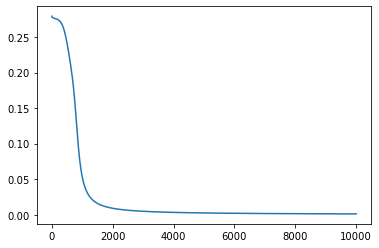

In [4]:
#TRAINING THE XOR FUNCTION

x_train = np.array([[0, 0, 1, 1], 
                    [0, 1, 0, 1]]) # 2 inputs and 4 samples, i.e 2x4
y_train = np.array([0, 1, 1, 0]) #1 x num of samples
Xor_net = NeuralNet('binary_logloss')
Xor_net.addLayer(3, 'tanh')
Xor_net.addLayer(1, 'sigmoid')
costs, weights = Xor_net.fit(x_train, y_train, 10000)
plt.plot(costs)

In [5]:
test = np.array([[1], [0]])
pred = 1 if Xor_net.predict(test) else 0
print("The result of the XOR b/w 1 and 0 is:", pred)

The result of the XOR b/w 1 and 0 is: 1


-----Epoch:  0 -----
Accuracy: 0.0
Cost: 0.8124434930660652
-----Epoch:  10 -----
Accuracy: 0.0
Cost: 0.5028903042489244
-----Epoch:  20 -----
Accuracy: 0.0
Cost: 0.4839048488523723
-----Epoch:  30 -----
Accuracy: 0.0
Cost: 0.46727603218511576
-----Epoch:  40 -----
Accuracy: 0.0
Cost: 0.45243846205140364
-----Epoch:  50 -----
Accuracy: 0.0
Cost: 0.4391539604120788
-----Epoch:  60 -----
Accuracy: 0.0
Cost: 0.427215242450443
-----Epoch:  70 -----
Accuracy: 0.0
Cost: 0.41644314571245805
-----Epoch:  80 -----
Accuracy: 0.0
Cost: 0.40668369950956534
-----Epoch:  90 -----
Accuracy: 0.0
Cost: 0.39780505389300075
-----Epoch:  100 -----
Accuracy: 0.0
Cost: 0.38969451294912255
-----Epoch:  110 -----
Accuracy: 0.0
Cost: 0.3822558052657171
-----Epoch:  120 -----
Accuracy: 0.0
Cost: 0.37540665113462945
-----Epoch:  130 -----
Accuracy: 0.0
Cost: 0.36907664030567067
-----Epoch:  140 -----
Accuracy: 0.0
Cost: 0.36320540772275783
-----Epoch:  150 -----
Accuracy: 0.125
Cost: 0.3577410811286928
-----Epoc

-----Epoch:  1690 -----
Accuracy: 0.375
Cost: 0.19514973150777185
-----Epoch:  1700 -----
Accuracy: 0.375
Cost: 0.1948667115753517
-----Epoch:  1710 -----
Accuracy: 0.375
Cost: 0.19458610787514613
-----Epoch:  1720 -----
Accuracy: 0.375
Cost: 0.19430788753194048
-----Epoch:  1730 -----
Accuracy: 0.375
Cost: 0.1940320182641872
-----Epoch:  1740 -----
Accuracy: 0.375
Cost: 0.19375846837065558
-----Epoch:  1750 -----
Accuracy: 0.375
Cost: 0.19348720671744624
-----Epoch:  1760 -----
Accuracy: 0.375
Cost: 0.19321820272535717
-----Epoch:  1770 -----
Accuracy: 0.375
Cost: 0.1929514263575893
-----Epoch:  1780 -----
Accuracy: 0.375
Cost: 0.19268684810778214
-----Epoch:  1790 -----
Accuracy: 0.375
Cost: 0.19242443898836803
-----Epoch:  1800 -----
Accuracy: 0.375
Cost: 0.1921641705192343
-----Epoch:  1810 -----
Accuracy: 0.375
Cost: 0.1919060147166858
-----Epoch:  1820 -----
Accuracy: 0.375
Cost: 0.1916499440826953
-----Epoch:  1830 -----
Accuracy: 0.375
Cost: 0.19139593159443555
-----Epoch:  184

-----Epoch:  3090 -----
Accuracy: 0.625
Cost: 0.16996569401691278
-----Epoch:  3100 -----
Accuracy: 0.625
Cost: 0.16984965731700818
-----Epoch:  3110 -----
Accuracy: 0.625
Cost: 0.16973417068533236
-----Epoch:  3120 -----
Accuracy: 0.625
Cost: 0.16961922960502163
-----Epoch:  3130 -----
Accuracy: 0.625
Cost: 0.16950482960947022
-----Epoch:  3140 -----
Accuracy: 0.625
Cost: 0.16939096628163178
-----Epoch:  3150 -----
Accuracy: 0.625
Cost: 0.16927763525333175
-----Epoch:  3160 -----
Accuracy: 0.625
Cost: 0.1691648322045922
-----Epoch:  3170 -----
Accuracy: 0.625
Cost: 0.1690525528629665
-----Epoch:  3180 -----
Accuracy: 0.625
Cost: 0.1689407930028858
-----Epoch:  3190 -----
Accuracy: 0.625
Cost: 0.16882954844501624
-----Epoch:  3200 -----
Accuracy: 0.625
Cost: 0.16871881505562583
-----Epoch:  3210 -----
Accuracy: 0.625
Cost: 0.1686085887459632
-----Epoch:  3220 -----
Accuracy: 0.625
Cost: 0.16849886547164405
-----Epoch:  3230 -----
Accuracy: 0.625
Cost: 0.16838964123205075
-----Epoch:  3

-----Epoch:  4390 -----
Accuracy: 0.625
Cost: 0.15829964754694537
-----Epoch:  4400 -----
Accuracy: 0.625
Cost: 0.15822965028929162
-----Epoch:  4410 -----
Accuracy: 0.625
Cost: 0.15815987536543566
-----Epoch:  4420 -----
Accuracy: 0.625
Cost: 0.15809032146448068
-----Epoch:  4430 -----
Accuracy: 0.625
Cost: 0.15802098728613548
-----Epoch:  4440 -----
Accuracy: 0.625
Cost: 0.15795187154060675
-----Epoch:  4450 -----
Accuracy: 0.625
Cost: 0.15788297294849235
-----Epoch:  4460 -----
Accuracy: 0.625
Cost: 0.15781429024067553
-----Epoch:  4470 -----
Accuracy: 0.625
Cost: 0.15774582215822058
-----Epoch:  4480 -----
Accuracy: 0.625
Cost: 0.15767756745226924
-----Epoch:  4490 -----
Accuracy: 0.625
Cost: 0.15760952488393967
-----Epoch:  4500 -----
Accuracy: 0.625
Cost: 0.15754169322422595
-----Epoch:  4510 -----
Accuracy: 0.625
Cost: 0.1574740712538978
-----Epoch:  4520 -----
Accuracy: 0.625
Cost: 0.15740665776340326
-----Epoch:  4530 -----
Accuracy: 0.625
Cost: 0.15733945155277146
-----Epoch:

-----Epoch:  5640 -----
Accuracy: 0.625
Cost: 0.15093894823728604
-----Epoch:  5650 -----
Accuracy: 0.625
Cost: 0.1508891460641746
-----Epoch:  5660 -----
Accuracy: 0.625
Cost: 0.15083945968635257
-----Epoch:  5670 -----
Accuracy: 0.625
Cost: 0.15078988857066122
-----Epoch:  5680 -----
Accuracy: 0.625
Cost: 0.15074043218733782
-----Epoch:  5690 -----
Accuracy: 0.625
Cost: 0.1506910900099876
-----Epoch:  5700 -----
Accuracy: 0.625
Cost: 0.15064186151555747
-----Epoch:  5710 -----
Accuracy: 0.625
Cost: 0.15059274618430843
-----Epoch:  5720 -----
Accuracy: 0.625
Cost: 0.15054374349978913
-----Epoch:  5730 -----
Accuracy: 0.625
Cost: 0.15049485294880968
-----Epoch:  5740 -----
Accuracy: 0.625
Cost: 0.1504460740214155
-----Epoch:  5750 -----
Accuracy: 0.625
Cost: 0.15039740621086106
-----Epoch:  5760 -----
Accuracy: 0.625
Cost: 0.1503488490135851
-----Epoch:  5770 -----
Accuracy: 0.625
Cost: 0.15030040192918437
-----Epoch:  5780 -----
Accuracy: 0.625
Cost: 0.1502520644603887
-----Epoch:  57

-----Epoch:  7070 -----
Accuracy: 0.625
Cost: 0.14478480707043878
-----Epoch:  7080 -----
Accuracy: 0.625
Cost: 0.14474741119058418
-----Epoch:  7090 -----
Accuracy: 0.625
Cost: 0.14471007963675994
-----Epoch:  7100 -----
Accuracy: 0.625
Cost: 0.14467281217342917
-----Epoch:  7110 -----
Accuracy: 0.625
Cost: 0.14463560856625812
-----Epoch:  7120 -----
Accuracy: 0.625
Cost: 0.14459846858210698
-----Epoch:  7130 -----
Accuracy: 0.625
Cost: 0.14456139198902349
-----Epoch:  7140 -----
Accuracy: 0.625
Cost: 0.14452437855623437
-----Epoch:  7150 -----
Accuracy: 0.625
Cost: 0.1444874280541378
-----Epoch:  7160 -----
Accuracy: 0.625
Cost: 0.14445054025429635
-----Epoch:  7170 -----
Accuracy: 0.625
Cost: 0.14441371492942887
-----Epoch:  7180 -----
Accuracy: 0.625
Cost: 0.14437695185340327
-----Epoch:  7190 -----
Accuracy: 0.625
Cost: 0.14434025080122945
-----Epoch:  7200 -----
Accuracy: 0.625
Cost: 0.14430361154905155
-----Epoch:  7210 -----
Accuracy: 0.625
Cost: 0.1442670338741405
-----Epoch: 

-----Epoch:  8510 -----
Accuracy: 0.625
Cost: 0.13996479429723793
-----Epoch:  8520 -----
Accuracy: 0.625
Cost: 0.13993471248648867
-----Epoch:  8530 -----
Accuracy: 0.625
Cost: 0.1399046704964458
-----Epoch:  8540 -----
Accuracy: 0.625
Cost: 0.13987466820678537
-----Epoch:  8550 -----
Accuracy: 0.625
Cost: 0.13984470549769465
-----Epoch:  8560 -----
Accuracy: 0.625
Cost: 0.13981478224986907
-----Epoch:  8570 -----
Accuracy: 0.625
Cost: 0.1397848983445095
-----Epoch:  8580 -----
Accuracy: 0.625
Cost: 0.13975505366331986
-----Epoch:  8590 -----
Accuracy: 0.625
Cost: 0.13972524808850412
-----Epoch:  8600 -----
Accuracy: 0.625
Cost: 0.13969548150276342
-----Epoch:  8610 -----
Accuracy: 0.625
Cost: 0.13966575378929402
-----Epoch:  8620 -----
Accuracy: 0.625
Cost: 0.13963606483178373
-----Epoch:  8630 -----
Accuracy: 0.625
Cost: 0.13960641451441047
-----Epoch:  8640 -----
Accuracy: 0.625
Cost: 0.13957680272183823
-----Epoch:  8650 -----
Accuracy: 0.625
Cost: 0.1395472293392157
-----Epoch:  

-----Epoch:  9920 -----
Accuracy: 0.625
Cost: 0.13606828631886433
-----Epoch:  9930 -----
Accuracy: 0.625
Cost: 0.13604282838461676
-----Epoch:  9940 -----
Accuracy: 0.625
Cost: 0.13601739732088122
-----Epoch:  9950 -----
Accuracy: 0.625
Cost: 0.13599199305862691
-----Epoch:  9960 -----
Accuracy: 0.625
Cost: 0.13596661552907446
-----Epoch:  9970 -----
Accuracy: 0.625
Cost: 0.13594126466369513
-----Epoch:  9980 -----
Accuracy: 0.625
Cost: 0.13591594039420946
-----Epoch:  9990 -----
Accuracy: 0.625
Cost: 0.13589064265258563


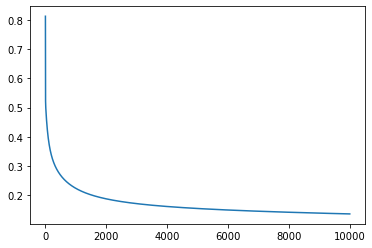

In [6]:
#TRAINING ON FLOWER PROBLEM (petal length and age --> color)

X_train = np.array([[3, 2, 4, 3, 3.5, 2, 5.5, 1],
                    [1.5, 1, 1.5, 1, 0.5, 0.5, 1, 1]])
y_train = np.array([1, 0, 1, 0, 1, 0, 1, 0])

Flower_net = NeuralNet('binary_logloss')
Flower_net.addLayer(1, 'sigmoid')
costs, weights = Flower_net.fit(X_train, y_train, 10000)
plt.plot(costs)

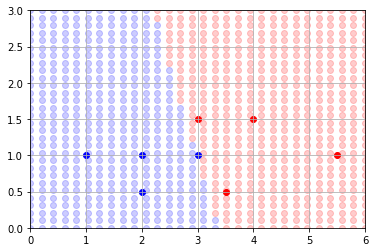

In [7]:
#Visualizing Flower problem

def vis_data():
    plt.axis([0, 6, 0 ,3])
    plt.grid()
    for i in range(X_train.shape[1]):
        point  = X_train[:, i]
        color = 'r'
        if y_train[i] == 0:
            color = 'b'
        plt.scatter(point[0], point[1], c=color)
    
# check out the networks predictions in the x,y plane
for x in np.linspace(0, 6, 30):
    for y in np.linspace(0, 3, 30):
        test = np.array([[x],[y]])
        pred = Flower_net.predict(test)
        c = 'b'
        if pred > .5:
            c = 'r'
        plt.scatter([x],[y],c=c, alpha=.2)

vis_data()

In [8]:
#TRAINING ON MNIST

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

In [ ]:
# Load data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])

X = X[permutation]
y = y[permutation].astype(np.int)
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=60000, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train).T
X_test = scaler.transform(X_test).T

In [ ]:
mnist_net = NeuralNet('multi_logloss')
mnist_net.addLayer(64, 'reLu')
mnist_net.addLayer(10, 'softmax')
costs, weights = mnist_net.fit(X_train, y_train, 2000, 60000)
plt.plot(costs)

In [ ]:
y_pred = mnist_net.predict(X_test)
test_accuracy = 100*np.sum(y_test == np.argmax(y_pred, 0), axis=0) / X_test.shape[1]
print("Test Accuracy on MNIST: " + test_accuracy)